In [1]:
# This Jupyter notebook was created by Emily Olafson to predicit cognitive scores from structural and functional connectivity data in stroke subjects.
# Last updated: May 13 2022
# https://github.com/emilyolafson/cognition_nemo

#import relevant libraries
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime
import pickle 
from sklearn.pipeline import Pipeline
import scipy.io as sio
from scipy.stats import spearmanr, pearsonr
from joblib import parallel_backend, Parallel, delayed
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils.fixes import loguniform
import matplotlib as mpl
from numpy import genfromtxt
import nibabel as nib
import os

In [4]:
import seaborn as sns

# Set paths
data_dir='/home/ubuntu/iowa_reg/'
results_dir='/home/ubuntu/iowa_reg/results/' 

#Load input variables (estimated SC) a
nROIs=86
df =  pd.read_csv(data_dir + 'digitspanRegistry.csv', header=0)
subs =  pd.read_csv('/home/ubuntu/iowa_reg/data/fs86_SC/allsubjects.csv', header=None) # load subject list
epilepsy =  pd.read_csv('/home/ubuntu/iowa_reg/epilepsy.csv', header=None) # load subject list

ep_pos = epilepsy ==1

subj_id=np.zeros([len(subs)])

subs=np.array(subs)
sc= np.zeros([len(subj_id),3655])
# load sc
for i in range(0, len(subs)):
    if subs[i][0] < 1000:
        num = str(subs[i][0])
        num_filled = num.zfill(4) # z fill add num of zeros + 1
    if subs[i][0] < 100:
        num = str(subs[i][0]) 
        num_filled = str(num.zfill(4))
    elif subs[i][0] > 1000:
        num_filled = str(subs[i][0]) 
    
    filename = data_dir + "data/fs86_SC/%s_nemo_output_sdstream_chacoconn_fs86subj_nemoSC_mean.mat" % (num_filled)
    sc_tmp = sio.loadmat(filename)
    scsub=sc_tmp['SC']

    np.fill_diagonal(scsub, 0)
    sc[i,:] = scsub[np.triu_indices(nROIs,k=1)]
    
# load digit span 
y = pd.read_csv(data_dir + 'digitspanRegistry_plusaverageDS.csv', header=0)
y = y['average']
ds = np.array(y,ndmin=2).transpose()
print(ds.shape)

# drop epilepsy subjects
ep_pos=np.array(ep_pos).ravel()
sc_noep=np.delete(sc, ep_pos, axis=0)
ds_noep=np.delete(ds, ep_pos, axis=0)

print(ds_noep.shape)
print(sc_noep.shape)

(808, 1)
(686, 1)
(686, 3655)


/home/ubuntu/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


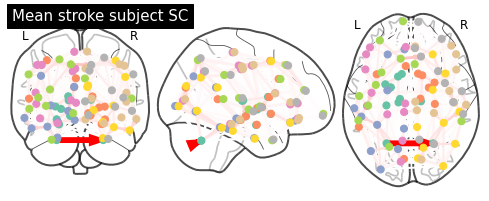

In [5]:
# SC average across stroke subjects
from nilearn import datasets
from nilearn import plotting

fs86 = np.zeros((86, 86))
inds = np.triu_indices(86, k=1)
fs86[inds] = np.mean(sc, axis=0)

sub = np.zeros((86, 86))

coordinates = plotting.find_parcellation_cut_coords('/home/ubuntu/cognition_iowa/fs86_allsubj_mode.nii.gz')
plotting.plot_connectome(fs86, coordinates,edge_threshold="90%",
                         title='Mean stroke subject SC')


In [3]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    FROM: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def prepare_data(X):
    '''Clean X-data (remove zero-value input variables)'''

    # remove inputs that are 0 for all subjects
    zeros=X==0
    zeros=np.sum(zeros,0)
    zeros=zeros==X.shape[0]
    X=X[:,~zeros]
    print("Final size of X: " + str(X.shape))
    
    return X

def prepare_image_data(X):
    '''Clean X-data (remove zero-value input variables)'''

    # remove inputs that are 0 for all subjects
    X=np.reshape(X, (101,902629))
    print("Final size of X: " + str(X.shape))
    
    return X

def np_pearson_cor(x, y):
    '''Fast array-based pearson correlation that is more efficient. 
    FROM: https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)


def naive_pearson_cor(X, Y):
    '''Naive (scipy-based/iterative) pearson correlation. 
    FROM: https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    result = np.zeros(shape=(X.shape[1], Y.shape[1]))
    for i in range(X.shape[1]):
        for j in range(Y.shape[1]):
            r, _ = pearsonr(X[:,i], Y[:,j])
            result[i,j] = r
    return result[0]


def feature_select_PCA(x_train, x_test, a):
    """Return values for the top a PCs of x based on PCA of x.
         
         Inputs:
             x = input matrix
             y = variable/s predicted 
             a = number of PCs
         
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features 
            var_expl = variance explained by top a components
            components = PCs selected"""
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
    
    # Feature selection: use only the top n features based on top a PCs in training data 
    pca = PCA(n_components=a, copy=True, random_state=42)
    x_train_featselect = pca.fit(x_train).transform(x_train)
    x_test_featselect = pca.transform(x_test)
    components = pca.components_

    
    var_expl = pca.explained_variance_


    return x_train_featselect,x_test_featselect, components

def feature_select_correlation(x_train, x_test, y, a):
    """Return values for the top a features of x based on abs. value Spearman correlation with y.
         Inputs:
             x_train = input matrix for training subjects
             x_test = input matrix for test subjects
             y = variable/s predicted 
             a = number of features to retain
        
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features
            ind = indices of top a features """
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
        
        
    # Feature selection: use only the top n features based on correlation of training features with y
    correl = abs(np_pearson_cor(x_train, y))
    ind = np.argpartition(correl, -a, 0)[-a:] # select top a features

    # return training/test data with only top features
    x_train_featselect=np.squeeze(x_train[:,ind],2)
    
    x_test_featselect=np.squeeze(x_test[:,ind],2)

    return x_train_featselect,x_test_featselect, ind


def scale_data(x_train, x_test):
    '''Scale the training data and apply transformation to the test/validation data.

        Inputs:
            x_train = training predictors
            x_test = training predictors 
        
        Returns:
            x_train_scaled
            x_test_scaled '''
    
    # Scale x_train 
    scaler = preprocessing.StandardScaler().fit(x_train)
    
    # apply transformation to train & test set.
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    return x_train_scaled, x_test_scaled

def normalize_data(x_train, x_test):
    '''subtracting the mean and dividing by the l2-norm'''
    x_train_mean=np.mean(x_train)
    x_train_norm=np.linalg.norm(x_train)
    
    x_test_mean=np.mean(x_test)
    x_test_norm=np.linalg.norm(x_test)
    
    x_train=(x_train-x_train_mean)/x_train_norm
    x_test=(x_test-x_test_mean)/x_test_norm

    return x_train, x_test

def gcv_ridge(hyperparam, x, y, k, featsel='None', a=10):
    """Perform gridsearch using k-fold cross-validation on a single hyperparameter 
    in ridge regression, and return mean R^2 across inner folds.
    
    Inputs: 
        hyperparam = list of hyperparameter values to train & test on validation est
        x = N x p input matrix
        y = 1 x p variable to predict
        k = k value in k-fold cross validation 
        featsel = type string, feature selection method, default="None"
            'None' - no feature selection; use all variables for prediction
            'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
            'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
        a = number of features to select using one of the above methods, default=10 
    
    Returns:
        expl_var = the mean R^2 (coefficient of determination) across inner loop folds for the given hyperparameter
    """
    
    # make sure k is reasonable 
    if x.shape[0]/k <= 2:
        raise Exception('R^2 is not well-defined with less than 2 subjects.')   
    
    # set alpha in ridge regression
    alpha = hyperparam
    # Initialize lists with final results
    y_pred_total = []
    y_valid_total = []
    R2 = []
    comp = []
    correl=[]
    explvar=[]
    # Split data into test and train: random state fixed for reproducibility
    kf = KFold(n_splits=k,shuffle=True,random_state=43)
    
    # K-fold cross-validation 
    for train_index, valid_index in kf.split(x):
        x_train, x_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        #x_train, x_valid = scale_data(x_train, x_valid)
        
        if featsel=='correlation':
            x_train, x_valid, ind = feature_select_correlation(x_train, x_valid, y_train, a)
            comp.append(ind)
            
        elif featsel=='PCA':
            x_train, x_valid, components = feature_select_PCA(x_train, x_valid, a)
            comp.append(components)
        
        # Fit ridge regression with (x_train_scaled, y_train), and predict x_train_scaled
        regr = linear_model.Ridge(alpha=alpha, normalize=True, max_iter=1000000, random_state=42)
        y_pred = regr.fit(x_train, y_train).predict(x_valid)

        R2.append(r2_score(y_valid, y_pred))
        correlation=np_pearson_cor(y_pred, y_valid)[0]
        correl.append(correlation)
        explvar.append(explained_variance_score(y_valid, y_pred))
        
        # Append y_pred and y_valid values of this k-fold step to list with all values
        y_pred_total.append(y_pred)
        y_valid_total.append(y_valid)
 
    # note: don't use r2_score for ridge regression bc it does not account for bias error
    r2=np.mean(R2)
    
    cor=np.mean(correl)
    
    # use explained_variance_score instead:
    expl_var=np.mean(explvar)
    
    return expl_var

def gcv_ridge_strat(hyperparam, x, y, k, chronic_bin, featsel='None', a=10):
    """Perform gridsearch using k-fold cross-validation on a single hyperparameter 
    in ridge regression, and return mean R^2 across inner folds.
    
    Inputs: 
        hyperparam = list of hyperparameter values to train & test on validation est
        x = N x p input matrix
        y = 1 x p variable to predict
        k = k value in k-fold cross validation 
        featsel = type string, feature selection method, default="None"
            'None' - no feature selection; use all variables for prediction
            'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
            'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
        a = number of features to select using one of the above methods, default=10 
    
    Returns:
        expl_var = the mean R^2 (coefficient of determination) across inner loop folds for the given hyperparameter
    """
    
    # make sure k is reasonable 
    if x.shape[0]/k <= 2:
        raise Exception('R^2 is not well-defined with less than 2 subjects.')   
    
    # set alpha in ridge regression
    alpha = hyperparam
    # Initialize lists with final results
    y_pred_total = []
    y_valid_total = []
    R2 = []
    comp = []
    correl=[]
    explvar=[]
    # Split data into test and train: random state fixed for reproducibility
    kf = KFold(n_splits=k,shuffle=True,random_state=43)
    
    # K-fold cross-validation 
    for train_index, valid_index in kf.split(x):
        x_train, x_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        chron_train=chronic_bin[train_index] 
        chron_valid=chronic_bin[valid_index]
        
        #x_train, x_valid = scale_data(x_train, x_valid)
        
        if featsel=='correlation':
            x_train, x_valid, ind = feature_select_correlation(x_train, x_valid, y_train, a)
            comp.append(ind)
            
        elif featsel=='PCA':
            x_train, x_valid, components = feature_select_PCA(x_train, x_valid, a)
            comp.append(components)
            
        elif featsel =="none":
            x_train, x_valid, components = x_train, x_valid, x_train.shape[1]
            comp.append(components)
        
        # add chronicity variable after features selection
        chron_train=np.reshape(np.double(chron_train), (x_train.shape[0], 1))
        x_train=np.concatenate((x_train, chron_train),axis=1)
        
        chron_valid=np.reshape(np.double(chron_valid), (x_valid.shape[0], 1))
        x_valid=np.concatenate((x_valid, chron_valid),axis=1)
        
        # Fit ridge regression with (x_train_scaled, y_train), and predict x_train_scaled
        regr = linear_model.Ridge(alpha=alpha, normalize=True, max_iter=1000000, random_state=42)
        y_pred = regr.fit(x_train, y_train).predict(x_valid)

        R2.append(r2_score(y_valid, y_pred))
        correlation=np_pearson_cor(y_pred, y_valid)[0]
        correl.append(correlation)
        explvar.append(explained_variance_score(y_valid, y_pred))
        
        # Append y_pred and y_valid values of this k-fold step to list with total values
        y_pred_total.append(y_pred)
        y_valid_total.append(y_valid)

    # note: don't use r2_score for ridge regression bc it does not account for bias error
    r2=np.mean(R2)
    
    cor=np.mean(correl)
    
    # use explained_variance_score instead:
    expl_var=np.mean(explvar)
    
    
    return expl_var

def parallel_featsearch_strat(alpha, X, Y, k, chronic_bin, featselect, feat):
    ''' Stratified grid search in parallel.

    Returns:
        expl_var - explained variance for given combination of alpha/feat/featselect'''
    
    expl_var=gcv_ridge_strat(alpha, X, Y, k, chronic_bin, featselect, feat)
    
    return expl_var

def parallel_featsearch(alpha, X, Y, k, featselect, feat):
    ''' Grid search in parallel.

    Returns:
        expl_var - explained variance for given combination of alpha/feat/featselect'''
    
    expl_var=gcv_ridge(alpha, X, Y, k, featselect, feat)
    return expl_var

# Inner loop - grid search
def gridsearch_cv_strat(k, x, y, chronic_bin, featselect, alphas, feats):
    ''' Performs grid search using fixed predefined hyperparameter ranges and returns the best alpha and # of features for 
        a given training/validation sample. Uses stratified k-fold cross-validation for inner loop.
        
        Input:
            x = N x p input matrix
            y = 1 x p variable to predict
            k = k value in k-fold cross validation 
            featsel = type string, feature selection method, default="None"
                'None' - no feature selection; use all variables for prediction
                'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
                'PCA' - perform PCA on the training variables and use the top 'feats' PCs as input variables, by variance explained, for prediction
            chronic_bin - stratification binary variable
            featselect - type of features selection. can be "correlation" or "PCA"
            alphas - range of alpha parameters to search 
            feats - range of # features to search
        
        Returns:
            bestalpha - optimal alpha based on grid search
            bestfeats - optimal number of features based on grid search
            bestr2 - mean R^2 across folds obtained for the optimal combination of hyperparameters
            gcv_values - R^2 across all combinations of hyperparametrs.'''
    
    print(str(k)+"-fold cross-validation results in "+str((x.shape[0]/k)*(k-1))+ " subjects in the training set, and "+ str(x.shape[0]/k) + " subjects in the validation set")

    # initialize array to store r2
    gcv_values=np.empty(shape=(len(alphas),len(feats)),dtype='float')

    # iterate through alphas
    for alpha in alphas:
        row, = np.where(alphas==alpha)
        
        # run feature selection (# of components) in parallel
        gcv=Parallel(n_jobs=-1,verbose=0)(delayed(parallel_featsearch_strat)(alpha,x, y, k, chronic_bin, featselect, feat) for feat in feats)
        gcv=np.array(gcv)
        gcv_values[row]=gcv
            
        row=np.argmax(np.max(gcv_values, axis=1))
        col=np.argmax(np.max(gcv_values, axis=0))

    bestalpha=alphas[row]
    bestfeats=feats[col]
    bestr2=np.max(gcv_values)

    return bestalpha, bestfeats, bestr2, gcv_values

# Inner loop - grid search
def gridsearch_cv(k, x, y, featselect, alphas, feats):
    ''' Performs grid search using fixed predefined hyperparameter ranges and returns the best alpha and # of features for 
        a given training/validation sample. 
        
        Input:
            x = N x p input matrix
            y = 1 x p variable to predict
            k = k value in k-fold cross validation 
            featsel = type string, feature selection method, default="None"
                'None' - no feature selection; use all variables for prediction
                'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
                'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
            alphas - range of alpha parameters to search 
            feats - range of # features to search
        
        Returns:
            bestalpha - optimal alpha based on grid search
            bestfeats - optimal number of features based on grid search
            bestr2 - mean R^2 across folds obtained for the optimal combination of hyperparameters
            gcv_values - R^2 across all combinations of hyperparametrs.'''
    
    print(str(k)+"-fold cross-validation results in "+str((x.shape[0]/k)*(k-1))+ " subjects in the training set, and "+ str(x.shape[0]/k) + " subjects in the validation set")

    # initialize array to store r2
    gcv_values=np.empty(shape=(len(alphas),len(feats)),dtype='float')

    # iterate through alphas
    for alpha in alphas:
        row, = np.where(alphas==alpha)
        
        # run feature selection (# of components) in parallel
        gcv=Parallel(n_jobs=-1,verbose=0)(delayed(parallel_featsearch)(alpha,x, y, k, featselect, feat) for feat in feats)
        gcv=np.array(gcv)
        gcv_values[row]=gcv
            
        row=np.argmax(np.max(gcv_values, axis=1))
        col=np.argmax(np.max(gcv_values, axis=0))

    bestalpha=alphas[row]
    bestfeats=feats[col]
    bestr2=np.max(gcv_values)

    return bestalpha, bestfeats, bestr2, gcv_values

def gridsearch_plsr(k, x, y, components):
    ''' Performs grid search for PLS regression using fixed predefined hyperparameter range and returns the best n components for 
        a given training/validation sample. Calculates PRESS (preedicted residual sum of squares) for each subject.

        Returns:
            presssum - sum of PRESS for all subjects'''
    
    presssum=[]
    # iterate through components
    for comp in components:
        
        row, = np.where(components==comp)
        
        kf = KFold(n_splits=k,shuffle=True,random_state=43)
        
        scores=[]
        press=[]
        
        # calculate PRESS for each held-out subject
        for i in range(0, x.shape[0]):
            trainx = np.delete(x, i, axis=0)
            trainy = np.delete(y, i, axis=0)
            
            pls = PLSRegression(n_components=comp, scale=True, copy=False)
            pls.fit(trainx, trainy)

            ypred = pls.predict(x[i,:].reshape(1, -1) )
            ytrue=y[i].reshape(1, -1)
            press.append(sum((ytrue.T-ypred.T)**2))
            
        presssum.append(np.sum(press))
        
    return presssum

def plot_figure(gcv_values, string, midpoint):
    '''Plots the R^2 value obtained across all grid-search pairs (# features and regularization values.)
    
    Inputs:
        gcv_values - matrix to plot
        string - title
        midpoint - point at which blue turns to red.'''
    
    plt.figure(figsize=(17,14))
    shifted_cmap = shiftedColorMap(plt.get_cmap('bwr'), midpoint=midpoint, name='shifted')

    plt.imshow(gcv_values, cmap=shifted_cmap, interpolation='nearest')

    plt.xlabel('# Features', fontsize=15, fontweight='bold')
    plt.ylabel('Alphas', fontsize=15, fontweight='bold')

    row=np.argmax(np.max(gcv_values, axis=0))
    col=np.argmax(np.max(gcv_values, axis=1))

    ax = plt.axes()

    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    xticks= np.linspace(feat_start, feat_end,n_feats, dtype=int)
    yticks= np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    plt.xticks(np.arange(len(feats)), fontsize=18)
    plt.yticks(np.arange(len(alphas)), fontsize=18)

    ax.set_xticklabels(xticks)
    ax.set_yticklabels(np.round(yticks,3))

    #ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{xticks: .2f}'))
    cbar = plt.colorbar()
    cbar.set_label('R^2')
    plt.title(string + '_Best R^2 = ' + str(np.round(np.max(gcv_values), 3)), fontsize=20)

    plt.scatter(row,col,color='k')
    plt.savefig(results_dir+string+ '.png')
    plt.show()

In [173]:
# -------------------- MODEL OPTIMIZATION --------------------
# range of alphas
n_alphas=20
alpha_start=-4
alpha_end=2
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10,dtype=None)
p=0
#number of features (# pricipal components or variables to retain)
feat_start=30
feat_end=100

n_feats=feat_end-feat_start+1
feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

#set the proportion of data you want in your training set
train_size = .8

#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5
#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=np.array(sc_noep)
X=prepare_data(X)

#set y to be the measure you want to predict
Y = ds_noep
Y=np.reshape(np.array(Y), (686,1))

featselect = 'correlation'

# set aside data for hold-out final testing: 
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=134)

bestalpha, bestfeats, bestr2, gcv_values_r2= gridsearch_cv(k, x, y, featselect, alphas, feats)

row=np.argmax(np.max(gcv_values_r2, axis=1))
col=np.argmax(np.max(gcv_values_r2, axis=0))
k = 5
bestalpha=alphas[row]
bestfeats=feats[col]

print('Best combination: \n alpha = ', str(alphas[row]), '\n Features = ', str(feats[col]), '\n R^2 = ', str(np.round(np.max(gcv_values_r2), 3)))


Final size of X: (686, 3192)
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
Best combination: 
 alpha =  2.6366508987303554 
 Features =  58 
 R^2 =  0.144


<ipython-input-101-c57a9c06fbb0>:528: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


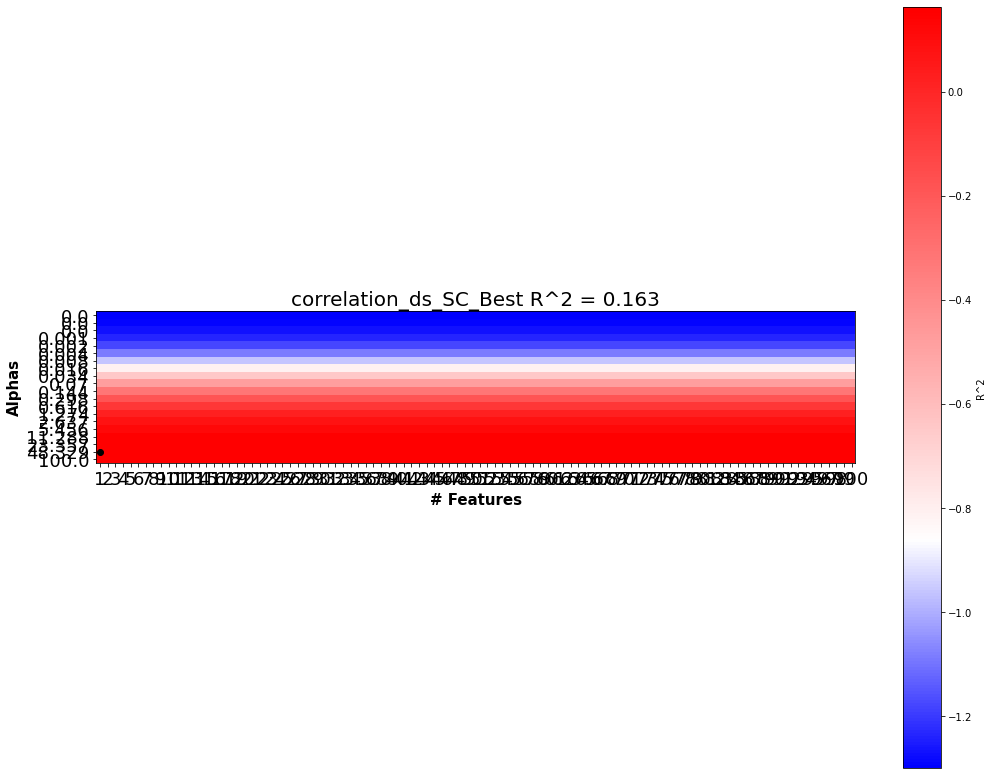

In [103]:
# plot variance explained over hyperparameter search space
plot_figure(gcv_values_r2,'correlation_ds_SC',0.3)

In [175]:
# predictions for SC - subjects with no epilepsy (stroke only)
results_dir='/home/ubuntu/iowa_reg/results/correlation_sc_noepilepsy/'
import datetime

# feature selection type
f=['correlation']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #X=np.concatenate([sc, fc], axis=1)
    X=sc_noep
    X=prepare_data(X)
    #set y to be the measure you want to predict
    #Y = np.log(np.array(tmt))

    Y=ds_noep
    Y=np.reshape(Y, (686,1))
    
    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=30
    feat_end=100
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    correlations=[]
    chronic_allexpl_var=[]
    #joblib-based parallelism to increase speed,
    ytestc=[]
    ypredc=[]
    for p in range(0, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        chronic_explvar=[]
        cor=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()
            
            #chronic_bin=chronic_id[train]
            #chronic_test=chronic_id[test]
            
            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)
                
            
            #chronic_bin=np.reshape(np.double(chronic_bin), (x_train_featselect.shape[0], 1))
            #x_train_featselect=np.concatenate((x_train_featselect, chronic_bin),axis=1)
        
            #chronic_test=np.reshape(np.double(chronic_test), (x_test_featureselect.shape[0], 1))
            #x_test_featureselect=np.concatenate((x_test_featureselect, chronic_test),axis=1)
                
            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("R2 loop: " + str(r2_score(Y[test], y_pred)))
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))
            
            #chronicsubs_test=chronic_id[test]==True
            #chronicsubs_train=chronic_id[train]==True
            #chronicsubs_test=chronicsubs_test.flatten()
            #chronicsubs_train=chronicsubs_train.flatten()
            cor.append(np_pearson_cor(Y[test], y_pred))
            Xtest=x_test_featureselect
            Xtrain=X[train]
            Ytest=Y[test]

            #ytrue_chronic = Ytest[chronicsubs_test]
            #xtest_chronic=Xtest[chronicsubs_test]
            
            #ytestc.append(ytrue_chronic)
            
            #ychronic_pred = regr.fit(x_train_featselect, Y[train]).predict(xtest_chronic)
            #print("Explained variance, chronic only:  " + str(explained_variance_score(ytrue_chronic, ychronic_pred)))
            #ypredc.append(ychronic_pred)

            #chronic_explvar.append(explained_variance_score(ytrue_chronic, ychronic_pred))
            
 
        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        #chronic_allexpl_var.append(chronic_explvar)
        correlations.append(cor)
        #print("---- Permutation avg. chronic explained variance: " + str(np.mean(chronic_explvar)) + "----")
        #np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_chronic_all_explvar.txt', chronic_allexpl_var, delimiter=',')

        print("---- Permutation avg. explained variance: " + str(np.mean(expl_var)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()
        
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_correlations.pkl', 'wb')
        pickle.dump(correlations, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
     
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_varimpt.pkl', 'wb')
        pickle.dump(impt, output)
        output.close()   

Final size of X: (686, 3192)
Permutation: 0
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
time to run loop: 0:00:17.854195
R2 loop: 0.2891049237236425
Explained var: 0.2908086842742065
correlation: [[0.57970401]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.944534
R2 loop: 0.17642366572649593
Explained var: 0.17671634617873122
correlation: [[0.42530923]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.862863
R2 loop: 0.05632402695312411
Explained var: 0.061925515602398895
correlation: [[0.27178166]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.874622
R2 loop: 0.07019313500704616
Explained var: 0.0708297260220565
correlation: [[0.28523718]]
5-fold cro

time to run loop: 0:00:17.922505
R2 loop: 0.030541000066968915
Explained var: 0.03081754059767494
correlation: [[0.2445651]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.637837
R2 loop: 0.2366799906363476
Explained var: 0.2518458698859536
correlation: [[0.52190046]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.526815
R2 loop: 0.18354674955985972
Explained var: 0.188703056514391
correlation: [[0.43444502]]
---- Permutation avg. explained variance: 0.15233589398808312----
Permutation: 7
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
time to run loop: 0:00:17.459388
R2 loop: 0.1579969480780975
Explained var: 0.16377121242359094
correlation: [[0.40735152]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subject

time to run loop: 0:00:17.498187
R2 loop: 0.1913637541277019
Explained var: 0.1995990280742631
correlation: [[0.45949948]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.320073
R2 loop: 0.12102394155737772
Explained var: 0.1242736950016966
correlation: [[0.35311402]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.244581
R2 loop: 0.12646385253165793
Explained var: 0.12867036139021193
correlation: [[0.35958377]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.147443
R2 loop: 0.14626448238889123
Explained var: 0.1476052356289017
correlation: [[0.38637793]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.009792
R2 loop: 0.161682886183

time to run loop: 0:00:17.049123
R2 loop: 0.07479249054750914
Explained var: 0.087605226222089
correlation: [[0.29879796]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.036271
R2 loop: 0.11746679669826698
Explained var: 0.1175486840647112
correlation: [[0.35057274]]
---- Permutation avg. explained variance: 0.15699147011990322----
Permutation: 20
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
time to run loop: 0:00:17.074636
R2 loop: 0.0595207402626885
Explained var: 0.05952543224918749
correlation: [[0.27402758]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.011588
R2 loop: 0.10825450387110447
Explained var: 0.11407744912474105
correlation: [[0.3385953]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjec

time to run loop: 0:00:16.946498
R2 loop: 0.13640195645343134
Explained var: 0.1402557644234279
correlation: [[0.37934779]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.037590
R2 loop: 0.1364246279703809
Explained var: 0.13649132306813927
correlation: [[0.37153402]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.064047
R2 loop: 0.23317390235343716
Explained var: 0.23325086994694266
correlation: [[0.48772684]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:16.974197
R2 loop: 0.11627027039038529
Explained var: 0.11722049852880934
correlation: [[0.34418006]]
---- Permutation avg. explained variance: 0.15767982007064982----
Permutation: 27
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 sub

time to run loop: 0:00:17.008180
R2 loop: 0.20816623097000198
Explained var: 0.21260973886500856
correlation: [[0.47084817]]
---- Permutation avg. explained variance: 0.15519206573578853----
Permutation: 33
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
time to run loop: 0:00:17.192349
R2 loop: 0.20514896714407993
Explained var: 0.21670980407000473
correlation: [[0.47611846]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.089852
R2 loop: 0.22874950474336264
Explained var: 0.23469422868495537
correlation: [[0.51907989]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.041407
R2 loop: 0.20091503643677888
Explained var: 0.20096213000703722
correlation: [[0.45595902]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 s

time to run loop: 0:00:17.223612
R2 loop: 0.14481241511943366
Explained var: 0.1457309677450287
correlation: [[0.38759256]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.107459
R2 loop: -0.054654305400198444
Explained var: -0.007706606448292241
correlation: [[0.21361965]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.187551
R2 loop: 0.22428887443203005
Explained var: 0.22432943257322102
correlation: [[0.50186542]]
---- Permutation avg. explained variance: 0.13372465163645023----
Permutation: 40
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
time to run loop: 0:00:17.087110
R2 loop: 0.18502083068405661
Explained var: 0.18992061902346957
correlation: [[0.43713616]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.

time to run loop: 0:00:17.204826
R2 loop: 0.0757154081648671
Explained var: 0.08187741396806447
correlation: [[0.32268086]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.210852
R2 loop: 0.11307504278024261
Explained var: 0.1131179666484522
correlation: [[0.33696056]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.490237
R2 loop: 0.1265992708252307
Explained var: 0.13768641694749706
correlation: [[0.37470722]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:16.980206
R2 loop: 0.19151478947242184
Explained var: 0.1915278900314069
correlation: [[0.43764783]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.981354
R2 loop: 0.204511177017

time to run loop: 0:00:17.678009
R2 loop: 0.22235803681963318
Explained var: 0.22280651415319364
correlation: [[0.49042905]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.578481
R2 loop: 0.07726982341157307
Explained var: 0.0849231542707235
correlation: [[0.29968586]]
---- Permutation avg. explained variance: 0.15633834447198772----
Permutation: 53
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
time to run loop: 0:00:17.323554
R2 loop: 0.16822820820943385
Explained var: 0.17720014246979288
correlation: [[0.43394432]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.096502
R2 loop: 0.23948903375549113
Explained var: 0.24275345680131177
correlation: [[0.50605047]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 su

time to run loop: 0:00:17.340406
R2 loop: 0.1275024646073677
Explained var: 0.12752026117036774
correlation: [[0.36181527]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.116127
R2 loop: 0.18209661579067782
Explained var: 0.18510608799038275
correlation: [[0.43233654]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.211996
R2 loop: 0.19836755779913096
Explained var: 0.20141731250317496
correlation: [[0.45416804]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.674554
R2 loop: 0.12848971019804478
Explained var: 0.14947358180421877
correlation: [[0.39211248]]
---- Permutation avg. explained variance: 0.15885978317693095----
Permutation: 60
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 su

time to run loop: 0:00:17.506155
R2 loop: 0.17908754407299865
Explained var: 0.1791202985688879
correlation: [[0.44233354]]
---- Permutation avg. explained variance: 0.15743001299907827----
Permutation: 66
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
time to run loop: 0:00:17.293662
R2 loop: 0.1945108292683705
Explained var: 0.19911591616251123
correlation: [[0.44649142]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:16.993973
R2 loop: 0.08520908981265973
Explained var: 0.0913970706433177
correlation: [[0.3049526]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.017175
R2 loop: 0.254309036674366
Explained var: 0.2543240359739666
correlation: [[0.5522917]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects 

time to run loop: 0:00:16.959002
R2 loop: 0.10912321088488774
Explained var: 0.11540349414880913
correlation: [[0.34631221]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:16.998614
R2 loop: 0.12787049309745835
Explained var: 0.12916603744144228
correlation: [[0.35961063]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.003690
R2 loop: 0.16502879402490922
Explained var: 0.17581290686557738
correlation: [[0.42963378]]
---- Permutation avg. explained variance: 0.15120966954134574----
Permutation: 73
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
time to run loop: 0:00:17.046886
R2 loop: 0.14488339502258984
Explained var: 0.1638519354258301
correlation: [[0.43396713]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 su

time to run loop: 0:00:17.370604
R2 loop: 0.1596213680540296
Explained var: 0.16684521339716363
correlation: [[0.41062593]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.123924
R2 loop: 0.11980116629131943
Explained var: 0.12164766925976533
correlation: [[0.34982719]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.085232
R2 loop: 0.028863737662394806
Explained var: 0.05684435590521819
correlation: [[0.26303143]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.066094
R2 loop: 0.19382796723076
Explained var: 0.19402124483906913
correlation: [[0.44406325]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.118154
R2 loop: 0.22488438575

time to run loop: 0:00:17.015418
R2 loop: 0.17193053727198704
Explained var: 0.17280050543027092
correlation: [[0.42266845]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.205694
R2 loop: 0.13576466818726873
Explained var: 0.1358544458965053
correlation: [[0.37209187]]
---- Permutation avg. explained variance: 0.16194513398835506----
Permutation: 86
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
time to run loop: 0:00:17.142533
R2 loop: 0.1578487894950945
Explained var: 0.15810019843222578
correlation: [[0.39770304]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.239278
R2 loop: 0.13446070845088842
Explained var: 0.15776170696782932
correlation: [[0.40253172]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 sub

time to run loop: 0:00:17.147147
R2 loop: 0.15637806421182832
Explained var: 0.1583997305405831
correlation: [[0.39799819]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.255393
R2 loop: 0.10769542420379663
Explained var: 0.11147187718521734
correlation: [[0.33441209]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.015833
R2 loop: 0.1854869875846138
Explained var: 0.18771124869763722
correlation: [[0.43694415]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.281930
R2 loop: 0.08263716179597369
Explained var: 0.10078805800121793
correlation: [[0.32232418]]
---- Permutation avg. explained variance: 0.1524562531594657----
Permutation: 93
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subj

time to run loop: 0:00:17.219928
R2 loop: -0.04844846182115048
Explained var: -0.04148514233803091
correlation: [[0.16518945]]
---- Permutation avg. explained variance: 0.14629102996187465----
Permutation: 99
5-fold cross-validation results in 438.4 subjects in the training set, and 109.6 subjects in the validation set
time to run loop: 0:00:17.157921
R2 loop: 0.21443264177070365
Explained var: 0.21882048603322513
correlation: [[0.4881849]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.209679
R2 loop: 0.13436638245206212
Explained var: 0.143566573714632
correlation: [[0.38419925]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 subjects in the validation set
time to run loop: 0:00:17.335883
R2 loop: 0.10910972412694564
Explained var: 0.12069590983658685
correlation: [[0.34799654]]
5-fold cross-validation results in 439.2 subjects in the training set, and 109.8 su

In [121]:
chronic_id.shape


(807, 1)

In [93]:
# -------- assessing model weights and features selected -----------
results_dir='/home/ubuntu/iowa_reg/results/correlation_sc/'
shape=[]
alldice=[]
alldicestd=[]
allalldice=[]
numfeatures=[]
countweights=np.zeros(shape=(3192, 1), dtype='int')
for p in range(0,100):
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_features.pkl', 'rb') as f:
        feats = pickle.load(f)
        
    # calculate the dice coefficient
    dice=np.zeros(shape=(5,5),dtype='float')
    for x in range(0,5):
        for y in range(0,5):
            if x==y :
                continue
            one=feats[x]
            two= feats[y]
            test=np.intersect1d(one,two)
            dice[x,y]=2*(test.shape[0]/(one.shape[0]+two.shape[0]))
    
    for x in range(0,5):
        numfeatures.append(feats[x].shape[0])
        
    dice=dice[np.triu_indices(5,k=1)] # only calcualting mean/std across 10 unique comparisons
    allalldice.append(dice)
    alldice.append(np.mean(dice))
    alldicestd.append(np.std(dice))
    
    # count how many times a feature shows up? max 5 per thing.
    for k in range(0, 3192):
        for x in range(0,5):
            if np.isin(k, feats[x]):
                countweights[k] = countweights[k] +1

In [103]:
alldice_null=[]
alldice_nullstd=[]
allalldice_null=[]
for k in range(0,100):
    # calculate the dice coefficient for randomly selected features
    dice_null=np.zeros(shape=(5,5),dtype='float')
    for x in range(0,5):
        for y in range(0,5):
            if x==y :
                continue
            one = np.random.randint(0,3193, size=(1,30))
            two =  np.random.randint(0,3193, size=(1,30))
            test=np.intersect1d(one,two)
            dice_null[x,y]=2*(test.shape[0]/(one.shape[1]+two.shape[1]))
     
    alldice_null.append(np.mean(dice_null))
    alldice_nullstd.append(np.std(dice_null))
    allalldice_null.append(dice_null)

alldice_null2=[]
alldice_nullstd2=[]
allalldice_null2=[]
for k in range(0,100):
    # calculate the dice coefficient for randomly selected features
    dice_null2=np.zeros(shape=(5,5),dtype='float')
    for x in range(0,5):
        for y in range(0,5):
            if x==y :
                continue
            one = np.random.randint(0,3193, size=(1,100))
            two =  np.random.randint(0,3193, size=(1,100))
            test=np.intersect1d(one,two)
            dice_null2[x,y]=2*(test.shape[0]/(one.shape[1]+two.shape[1]))
     
    alldice_null2.append(np.mean(dice_null2))
    alldice_nullstd2.append(np.std(dice_null2))
    allalldice_null2.append(dice_null2)

Text(0.5, 1.0, 'Proportion of outer folds including weight (x-axis)')

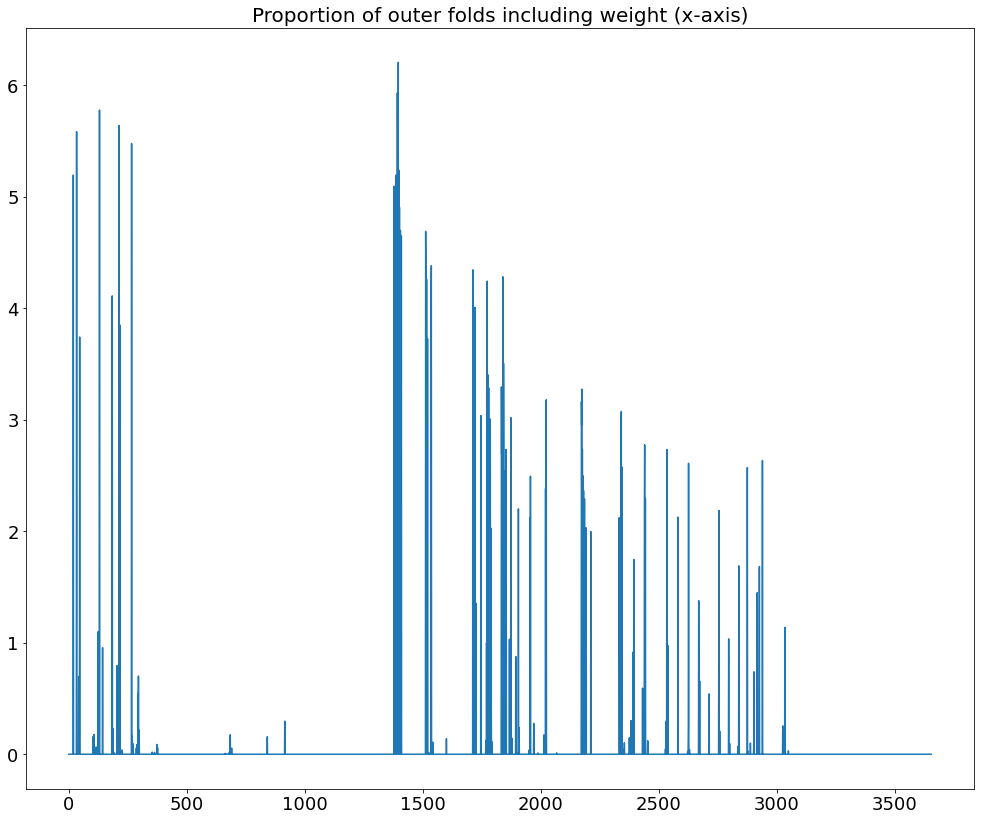

In [104]:
plt.figure(figsize=(17,14))

plt.plot(countweights/500)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Proportion of outer folds including weight (x-axis)', fontsize =20)

In [105]:
# convert vectorized Triu to matrix
highweights = countweights > 50

# get weights back to matrix form 86x86
# remove inputs that are 0 for all subjects
X=sc
zeros=X==0
zeros=np.sum(zeros,0) # number of zeros across subjects
zeros=zeros==X.shape[0] # find columns with zeros for all 101 subjects
tmp=np.ones(shape=(3192, 1))

zeroidx=np.arange(0, 3655)
zeroidx=zeroidx[zeros]

# fill spots with 0's
k=0
cnt = countweights
while k < zeroidx.shape[0]:
    cnt=np.insert(cnt, zeroidx[k],0)
    tmp=np.insert(tmp, zeroidx[k],0)

    k=k+1
    
plt.figure(figsize=(17,14))

fs86_counts = np.zeros((86, 86))
inds = np.triu_indices(86, k=1)
fs86_counts[inds] = cnt

plt.imshow(fs86_counts)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.colorbar()
plt.title('Number of times each SC edge was used in outer loop of cross-validation (max = 500)', fontsize = 19)

ValueError: shape mismatch: value array of shape (4118,)  could not be broadcast to indexing result of shape (3655,)

<Figure size 1224x1008 with 0 Axes>

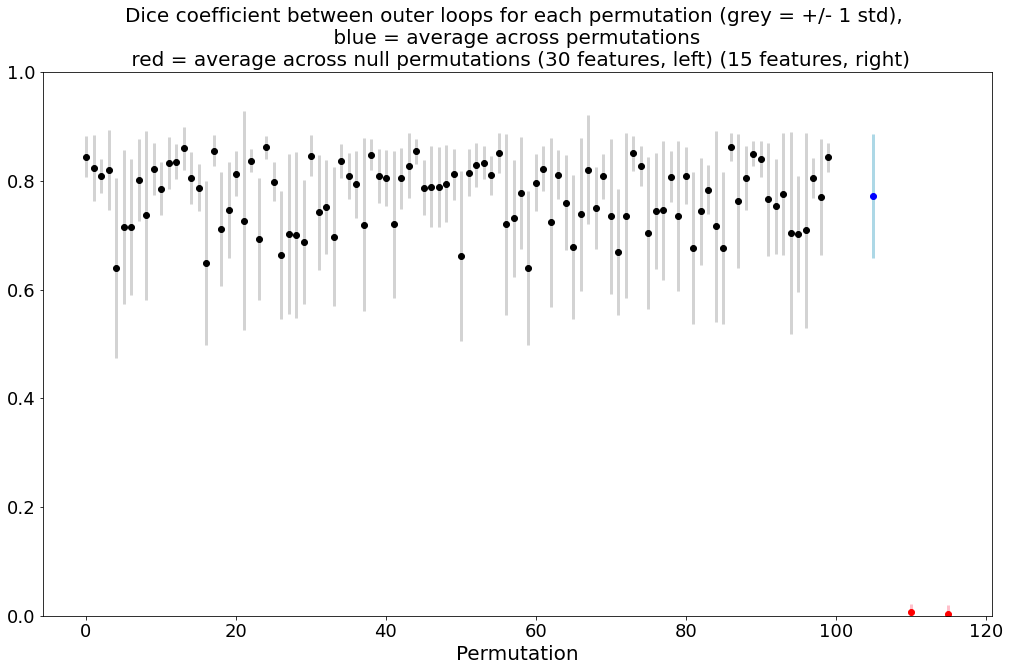

In [97]:
plt.figure(figsize=(17,10))
plt.errorbar(range(0,100), alldice, yerr=alldicestd, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);

plt.ylim([0, 1])
plt.title('Dice coefficient between outer loops for each permutation (grey = +/- 1 std), \n blue = average across permutations \n red = average across null permutations (30 features, left) (15 features, right)' , fontsize=20)
plt.xlabel('Permutation', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.errorbar(105, np.mean(allalldice), yerr=np.std(allalldice), fmt='o', color='blue',
             ecolor='lightblue', elinewidth=3, capsize=0);

plt.errorbar(110, np.mean(allalldice_null), yerr=np.std(allalldice_null), fmt='o', color='red',
             ecolor='pink', elinewidth=3, capsize=0);

plt.errorbar(115, np.mean(allalldice_null2), yerr=np.std(allalldice_null2), fmt='o', color='red',
             ecolor='pink', elinewidth=3, capsize=0);

In [98]:
# Haufe transformation of feature weights
k=5
results_dir='/home/ubuntu/iowa_reg/results/correlation_sc_noepilepsy/'
Y = np.array(ds)

perm=0
fullactivations=[] 
#iterate through permutations
for p in range(0,100):
    print('permutation' + str(p))
    k=5
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    
    # Load features selected from permutation
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_features.pkl', 'rb') as f:
        feats = pickle.load(f)
    
    c=0   
    # load activation weights
    with open(results_dir + 'correlation' + 'p' + str(p)+ '_SC_varimpt.pkl', 'rb') as f:
        activ = pickle.load(f)
    print(activ[0][0].shape)
    
    
    activations=[]
    X=sc
    X=prepare_data(X)
    fullactivation=[]
    activationweight=[]
    
    for train, test in outer_cv.split(X):
        x_train=X[train]
        X=x_train
        X_sub=X[:,feats[c][:]]
        
        X_sub=np.reshape(X_sub, [len(train),feats[c].shape[0]])
        cov_x=np.cov(np.transpose(X_sub))
        print(feats[c].shape[0])
        
        if feats[c].shape[0]==1:
            cov_x=np.reshape(cov_x, [1,1])
        
        #print(Y)
        cov_y=np.cov(np.transpose(Y[0][train]))
        if (p > 51) & (p < 54):
            activationweight=activ[p-52][c]
        elif p > 53:
            activationweight=activ[p-p-1][c]
        else:
            activationweight=activ[p][c]
     
        print(activationweight.shape)

        activationweight=activationweight# remove binary chronicity variable
        #print(activationweight.shape)
        weight=np.transpose(activationweight)

        activation=np.matmul(cov_x,weight)*(1/cov_y)
        activations.append(activation)
        #print(activation.shape)

        # get activation weights back to matrix form 86x86
        # get indices of weights not selected as features; set weight to 0    
        idx=np.ones(shape=(3192,1), dtype='bool')
        idx[feats[c]]=False # set SC weights that are features to be 1
        idx=idx.flatten()
        zeroidx=np.arange(0, 3192, dtype='int')
        zeroidx=zeroidx[idx]
        
        # fill spots with 0's (up to 3192)
        k=0
        activation_full = activation
        while k < zeroidx.shape[0]:
            activation_full=np.insert(activation_full, zeroidx[k],0)
            k=k+1
        
        #print("Full 3192: " + str(np.sum(activation_full>0)))
        # fill spots with 0's (up to 3655)
        X=sc
        zeros=sc==0
        zeros=np.sum(zeros,0) # number of zeros across subjects
        zeros=zeros==X.shape[0] # find columns with zeros for all 101 subjects
        X=X[:,~zeros]
        
        zeroidx=np.arange(0, 3655)
        zeroidx=zeroidx[zeros]

        # fill spots with 0's
        k=0
        a = activation_full
        while k < zeroidx.shape[0]:
            a=np.insert(a, zeroidx[k],0)
            k=k+1
        
        #print("Full 3655: " + str(np.sum(a>0)))
        fullactivation.append(a)
        c=c+1
         
    fullactivations.append(fullactivation)

permutation0
(1, 84)
Final size of X: (808, 3192)
84
(1, 84)
97
(1, 97)
92
(1, 92)
99
(1, 99)
98
(1, 98)
permutation1
(1, 84)
Final size of X: (808, 3192)
71
(1, 71)
99
(1, 99)
84
(1, 84)
61
(1, 61)
92
(1, 92)
permutation2
(1, 84)
Final size of X: (808, 3192)
72
(1, 72)
97
(1, 97)
69
(1, 69)
100
(1, 100)
98
(1, 98)
permutation3
(1, 84)
Final size of X: (808, 3192)
70
(1, 70)
87
(1, 87)
51
(1, 51)
82
(1, 82)
100
(1, 100)
permutation4
(1, 84)
Final size of X: (808, 3192)
96
(1, 96)
31
(1, 31)
92
(1, 92)
89
(1, 89)
100
(1, 100)
permutation5
(1, 84)
Final size of X: (808, 3192)
98
(1, 98)
64
(1, 64)
74
(1, 74)
33
(1, 33)
100
(1, 100)
permutation6
(1, 84)
Final size of X: (808, 3192)
99
(1, 99)
59
(1, 59)
76
(1, 76)
100
(1, 100)
35
(1, 35)
permutation7
(1, 84)
Final size of X: (808, 3192)
93
(1, 93)
58
(1, 58)
97
(1, 97)
92
(1, 92)
98
(1, 98)
permutation8
(1, 84)
Final size of X: (808, 3192)
93
(1, 93)
76
(1, 76)
72
(1, 72)
78
(1, 78)
30
(1, 30)
permutation9
(1, 84)
Final size of X: (808, 3

61
(1, 61)
81
(1, 81)
95
(1, 95)
98
(1, 98)
permutation77
(1, 100)
Final size of X: (808, 3192)
87
(1, 87)
36
(1, 36)
78
(1, 78)
78
(1, 78)
96
(1, 96)
permutation78
(1, 100)
Final size of X: (808, 3192)
77
(1, 77)
98
(1, 98)
81
(1, 81)
93
(1, 93)
85
(1, 85)
permutation79
(1, 100)
Final size of X: (808, 3192)
100
(1, 100)
37
(1, 37)
100
(1, 100)
97
(1, 97)
75
(1, 75)
permutation80
(1, 100)
Final size of X: (808, 3192)
100
(1, 100)
64
(1, 64)
100
(1, 100)
100
(1, 100)
65
(1, 65)
permutation81
(1, 100)
Final size of X: (808, 3192)
99
(1, 99)
30
(1, 30)
39
(1, 39)
82
(1, 82)
72
(1, 72)
permutation82
(1, 100)
Final size of X: (808, 3192)
42
(1, 42)
95
(1, 95)
99
(1, 99)
61
(1, 61)
90
(1, 90)
permutation83
(1, 100)
Final size of X: (808, 3192)
99
(1, 99)
75
(1, 75)
58
(1, 58)
100
(1, 100)
91
(1, 91)
permutation84
(1, 100)
Final size of X: (808, 3192)
100
(1, 100)
84
(1, 84)
88
(1, 88)
99
(1, 99)
31
(1, 31)
permutation85
(1, 100)
Final size of X: (808, 3192)
44
(1, 44)
95
(1, 95)
74
(1, 74)
9

In [100]:
countweights=np.zeros(shape=(3655, ), dtype='int')
print(len(fullactivations))

for p in range(0,100):
    act=fullactivations[p] # features 
    for x in range(0,5):
        #print(act[x].shape)
        countweights=countweights+act[x]

100


In [101]:
# convert vectorized Triu to matrix
highweights = countweights

plt.figure(figsize=(17,14))

fs86_counts = np.zeros((86, 86))
inds = np.triu_indices(86, k=1)
fs86_counts[inds] = highweights

<Figure size 1224x1008 with 0 Axes>

/home/ubuntu/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


<Figure size 1224x1008 with 0 Axes>

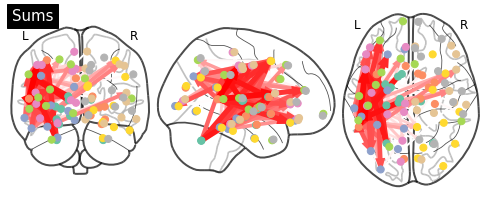

In [102]:
from nilearn import datasets
from nilearn import plotting

plt.figure(figsize=(17,14))

coordinates = plotting.find_parcellation_cut_coords('/home/ubuntu/cognition_iowa/fs86_allsubj_mode.nii.gz')
plotting.plot_connectome(fs86_counts, coordinates,
                         title='Sums')